In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt

In [2]:
import optuna
import optuna.integration
from optuna.integration import OptunaSearchCV

In [3]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")


In [3]:
def read_data_split_train(file):
    df = pd.read_csv("data.csv", sep=';')
    X, y = df.drop(["ID","TARGET"], axis=1), df["TARGET"]
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=8,stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=8,stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = read_data_split_train("data.csv")

In [5]:
clf = lgb.LGBMClassifier(random_state=8, importance_type="gain")
folds = KFold(n_splits=5, shuffle=True, random_state=8)

In [8]:
from sklearn.model_selection import cross_validate

cross_results = cross_validate(clf, X_train, y_train, cv=folds, scoring="roc_auc", return_train_score=True)

print("Train AUC scores: {}".format(cross_results["train_score"].mean()))
print("Validation AUC scores: {}".format(cross_results["test_score"].mean()))

Train AUC scores: 0.8949760056285457
Validation AUC scores: 0.7763954993342435


In [11]:
opt = OptunaSearchCV(clf, param_distributions={"max_depth": optuna.distributions.IntDistribution(2, 4),
                                               "learning_rate": optuna.distributions.FloatDistribution(high=0.1, log=True, low=0.001),},
                                               n_trials=10, verbose=1, random_state=8, n_jobs=-1, cv=folds, scoring="roc_auc", return_train_score=True)
opt.fit(X_train, y_train)

/tmp/ipykernel_21384/2999305469.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt = OptunaSearchCV(clf, param_distributions={"max_depth": optuna.distributions.IntDistribution(2, 4),
[I 2023-07-16 22:47:37,080] A new study created in memory with name: no-name-05b6a251-05f4-42cb-beca-96061eb812cf
[I 2023-07-16 22:47:37,081] Searching the best hyperparameters using 22950 samples...


[I 2023-07-16 22:47:39,904] Trial 3 finished with value: 0.7700880879144817 and parameters: {'max_depth': 2, 'learning_rate': 0.024103911720575973}. Best is trial 3 with value: 0.7700880879144817.
[I 2023-07-16 22:47:40,474] Trial 1 finished with value: 0.7809507882435245 and parameters: {'max_depth': 3, 'learning_rate': 0.06464967077868386}. Best is trial 1 with value: 0.7809507882435245.
[I 2023-07-16 22:47:40,489] Trial 0 finished with value: 0.7678051425235084 and parameters: {'max_depth': 3, 'learning_rate': 0.007507702535877446}. Best is trial 1 with value: 0.7809507882435245.
[I 2023-07-16 22:47:41,552] Trial 2 finished with value: 0.7594553683633679 and parameters: {'max_depth': 4, 'learning_rate': 0.0017515248438031183}. Best is trial 1 with value: 0.7809507882435245.
[I 2023-07-16 22:47:44,472] Trial 6 finished with value: 0.7594463647087546 and parameters: {'max_depth': 4, 'learning_rate': 0.0017589771284014682}. Best is trial 1 with value: 0.7809507882435245.
[I 2023-07-16 

OptunaSearchCV(cv=KFold(n_splits=5, random_state=8, shuffle=True),
               estimator=LGBMClassifier(importance_type='gain', random_state=8),
               n_jobs=-1,
               param_distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                    'max_depth': IntDistribution(high=4, log=False, low=2, step=1)},
               random_state=8, return_train_score=True, scoring='roc_auc',
               verbose=1)

In [26]:
opt.trials_[opt.best_index_].user_attrs['mean_train_score']

0.8230415540636402

In [11]:
mlflow.set_experiment("lgbm_gridcv_v1")

with mlflow.start_run(run_name='lgbm_v4'):
    
    eval_results={}
    lgb_callbacks=[lgb.early_stopping(10),lgb.log_evaluation(period=10),lgb.record_evaluation(eval_results)]
    params={"learning_rate": [0.01, 0.1],
                "n_estimators": [1000],
                "max_depth": [3, 5],
                "reg_lambda": [1, 0.1, 0.01],}
    mlflow.set_tag("model","lgbm")

    search = GridSearchCV(
                clf, params, cv=folds.split(X_train, y_train), scoring="roc_auc", n_jobs=-1, return_train_score=True,
            )

    search.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric="auc",
            callbacks=[lgb.early_stopping(10),lgb.log_evaluation(period=10),lgb.record_evaluation(eval_results)])

    mlflow.log_params(search.best_params_)
    mlflow.log_metric("best_score", search.best_score_)
    mlflow.log_metric("train_score",search.cv_results_["mean_train_score"][search.best_index_])
    mlflow.log_metric("test_score",search.cv_results_["mean_test_score"][search.best_index_])

    # get the best estimator and predict on the test data
    best_estimator = search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # calculate the ROC AUC score and log it to MLflow
    auc = roc_auc_score(y_test, y_pred)
    mlflow.log_metric("roc_auc", auc)

    # log the trained model as an artifact to MLflow
    mlflow.sklearn.log_model(best_estimator, "model")

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.737686	valid_0's binary_logloss: 0.510877	valid_1's auc: 0.72297	valid_1's binary_logloss: 0.511553
[10]	valid_0's auc: 0.735645	valid_0's binary_logloss: 0.510813	valid_1's auc: 0.722127	valid_1's binary_logloss: 0.511234
[10]	valid_0's auc: 0.750892	valid_0's binary_logloss: 0.511005	valid_1's auc: 0.732624	valid_1's binary_logloss: 0.511503
[20]	valid_0's auc: 0.766014	valid_0's binary_logloss: 0.497132	valid_1's auc: 0.751109	valid_1's binary_logloss: 0.498164
[10]	valid_0's auc: 0.753267	valid_0's binary_logloss: 0.510897	valid_1's auc: 0.743174	valid_1's binary_logloss: 0.511409
[20]	valid_0's auc: 0.759904	valid_0's binary_logloss: 0.497269	valid_1's auc: 0.746718	valid_1's binary_logloss: 0.497986
[20]	valid_0's auc:

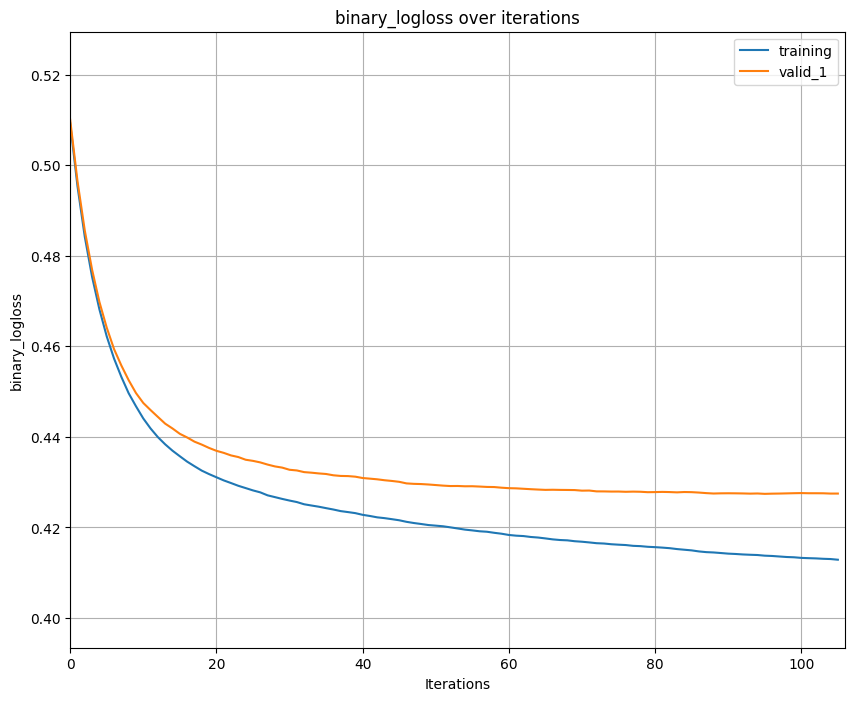

In [13]:
def plot_metric(metric="binary_logloss"):
        ax = lgb.plot_metric(eval_results, metric=metric, figsize=(10, 8))
        ax.set_title(f"{metric} over iterations")
        plt.show()
plot_metric()

In [ ]:
print("AUC Train: ", roc_auc_score(y_train, search.predict_proba(X_train)[:, 1]))
print("AUC Val: ", roc_auc_score(y_val, search.predict_proba(X_val)[:, 1]))
print("AUC Test: ", roc_auc_score(y_test, search.predict_proba(X_test)[:, 1]))

AUC Train:  0.8195778976608257
AUC Val:  0.7821125314226832
AUC Test:  0.7765452864540354


In [7]:
print("AUC Train: ", roc_auc_score(y_train, search.predict_proba(X_train)[:, 1]))
print("AUC Val: ", roc_auc_score(y_val, search.predict_proba(X_val)[:, 1]))
print("AUC Test: ", roc_auc_score(y_test, search.predict_proba(X_test)[:, 1]))

AUC Train:  0.8206714909982346
AUC Val:  0.7806617093373495
AUC Test:  0.7777312159597293


In [22]:
try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

In [23]:
def render_metric(metric_name):
    ax = lgb.plot_metric(eval_results, metric=metric_name, figsize=(10, 5))
    plt.show()

In [25]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name="auc")
else:
    render_metric("auc")

interactive(children=(Text(value='binary_logloss', description='metric_name'), Output()), _dom_classes=('widge…

In [25]:
search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_lambda': 0.01}

In [11]:
def plot_metric(metric="binary_logloss"):
        ax = lgb.plot_metric(eval_results, metric=metric, figsize=(10, 8))
        ax.set_title(f"{metric} over iterations")
        plt.show()

In [12]:
plot_metric()

NameError: name 'eval_results' is not defined

In [4]:
from LGBMClassifierSearch import LGBMClassifierSearch

In [5]:
busca = LGBMClassifierSearch()


In [6]:
busca.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric="auc",
              callbacks=[lgb.early_stopping(10),lgb.log_evaluation(period=10)])

Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.737688	valid_0's binary_logloss: 0.5108	valid_1's auc: 0.722941	valid_1's binary_logloss: 0.511513
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.737688	valid_0's binary_logloss: 0.5108	valid_1's auc: 0.722941	valid_1's binary_logloss: 0.511513
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.753454	valid_0's binary_logloss: 0.510811	valid_1's auc: 0.743112	valid_1's binary_logloss: 0.511325
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.753454	valid_0's binary_logloss: 0.510811	valid_1's auc: 0.743112	valid_1's binary_logloss: 0.511325
[10]	valid_0's auc: 0.73564	valid_0's binary_logloss: 0.510739	valid_1's auc: 0.722175	valid_1's binary_logloss: 0.511168
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.735653	valid_0's binary_logloss: 0.512285	

In [17]:
busca.search.cv_results_["params"][busca.search.best_index_]

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [18]:
busca.search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

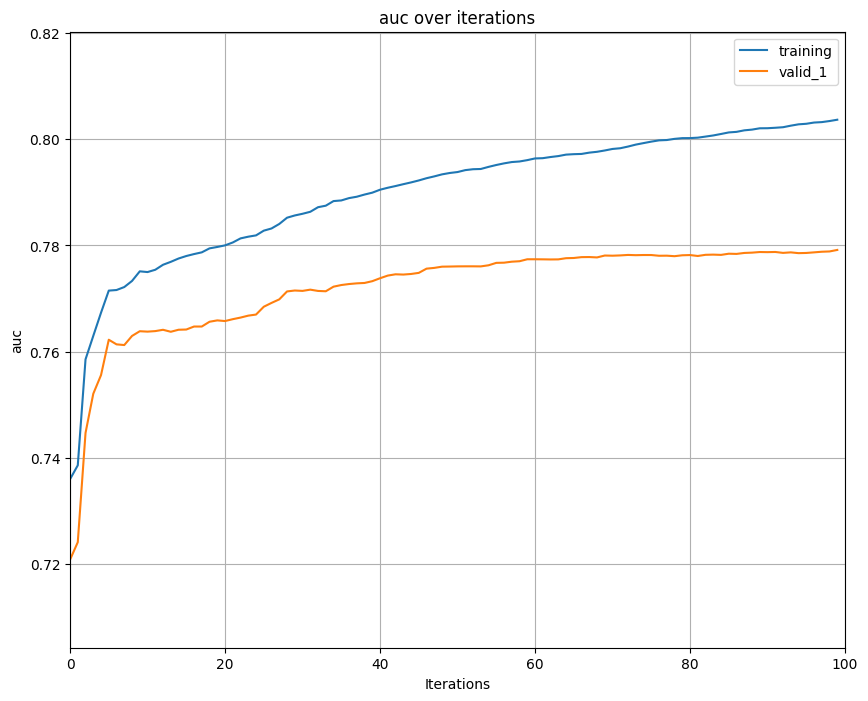

In [7]:
busca.plot_metric(metric="auc")

In [7]:
busca.plot_first_tree()

TypeError: BaseGraph.__init__() got an unexpected keyword argument 'figsize'

In [27]:
ax = lgb.create_tree_digraph(busca.search, tree_index=0, figsize=(8,6))
plt.show()

TypeError: booster must be Booster or LGBMModel.

In [11]:
dir(busca.search)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 '_validate_params',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_fe

In [13]:
type(busca.search.best_estimator_)

lightgbm.sklearn.LGBMClassifier